# Web Traffic Time Series Predictions

Web traffic, representing the number of user requests to a website, forms a substantial portion of Internet activity. Predictive models for web traffic are vital to prevent website crashes, minimize downtime, and implement strategies like load balancing. Ultimately, the objective is to enhance traffic control mechanisms by accurately predicting future web traffic, thereby ensuring a seamless and improved user experience for website visitors.

In [ ]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf

from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/bda_sem3/Time Series/Web_Traffic.csv', header=0).fillna(0)
page = train_df['Page']
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
# Fill missing values
train_df = train_df.fillna(0)

In [ ]:
#Time Frame
list(train_df.columns)[1], list(train_df.columns)[-1]

('2015-07-01', '2016-12-31')

We have daily time series data spanning from July 1, 2015, to December 31, 2016.

In [ ]:
#No of time stamps
len(list(train_df.columns)) -1

550

In [ ]:
#New data frame structure where each row represents a combination of a 'Page', a 'date', and the corresponding 'Visits' value.

# Select the columns of the DataFrame 'train_df' along with the 'Page' column,
# and then melt them into a long format DataFrame
train_df = pd.melt(train_df,id_vars=['Page'],var_name='date',value_name='Visits')

# Convert the 'date' column to datetime64 format to ensure it's treated as dates.
train_df['date'] = train_df['date'].astype('datetime64[ns]')

In [ ]:
# Grouping visistes wrt date to attain an univariate model
# Only one variable 'visit' varies over time.

# Group the DataFrame 'train_df' by the 'date' column and aggregate the 'Visits' column by summing the values.
# This effectively combines rows with the same date and sums their 'Visits' values.

df = train_df.groupby(['date']).agg({'Visits':'mean'}).rename(columns={'Visits':'visit'}).astype('float')

# Convert the 'visit' column to a floating-point data type.
# This ensures that the 'visit' column contains floating-point numbers instead of integers.

In [ ]:
df.head()

,visit
date,
2015-07-01,1024.882127
2015-07-02,1031.233602
2015-07-03,973.123388
2015-07-04,1003.791022
2015-07-05,1044.341920


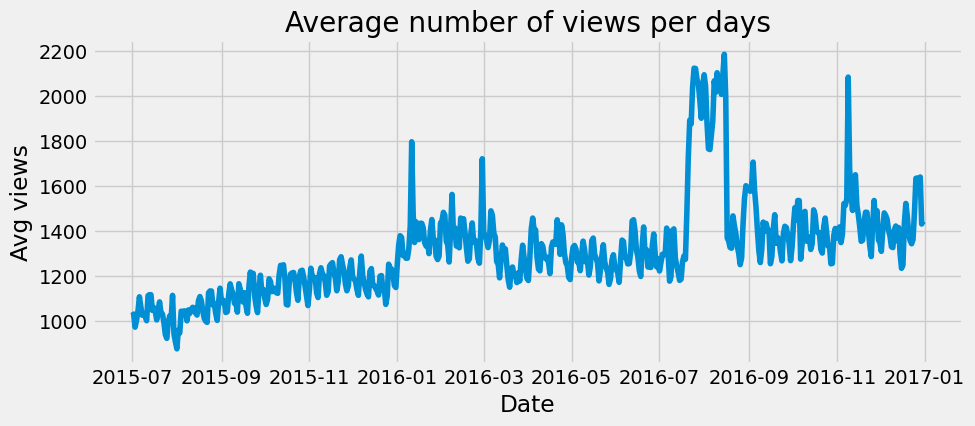

In [ ]:
#visualising
plt.figure(figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per days')
plt.plot(df.visit)
plt.show()

In [ ]:
#ADF Test
def check_stationarity(ts):
    dftest = sm.tsa.adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [ ]:
check_stationarity(df)

The series is NOT stationary


In [ ]:
#KPSS test
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df['visit'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.939446
Critical Values @ 0.05: 0.46
p-value: 0.010000


The p-value (0.010000) < 0.05 – Fail to Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is trend stationary.

## Model 0: Naïve forecast (baseline)



One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula: $\hat{y}_{t} = y_{t-1}$

Where,
$\hat{y}_{t}$ represents the forecasted value for the next time period and
$ y_{t-1}$ is the most recent observed value at time t.


In [ ]:
# Create train and test splits for time series data

# Ceate an abitrary point in time to split our data.
# Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

#Timestamps and series
timesteps = df.index.values
series = df.visit.values

split_size = int(0.8 * len(series)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], series[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], series[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(440, 110, 440, 110)

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Average views per page")

  if label:
    plt.legend(fontsize=10)
  plt.grid(True)

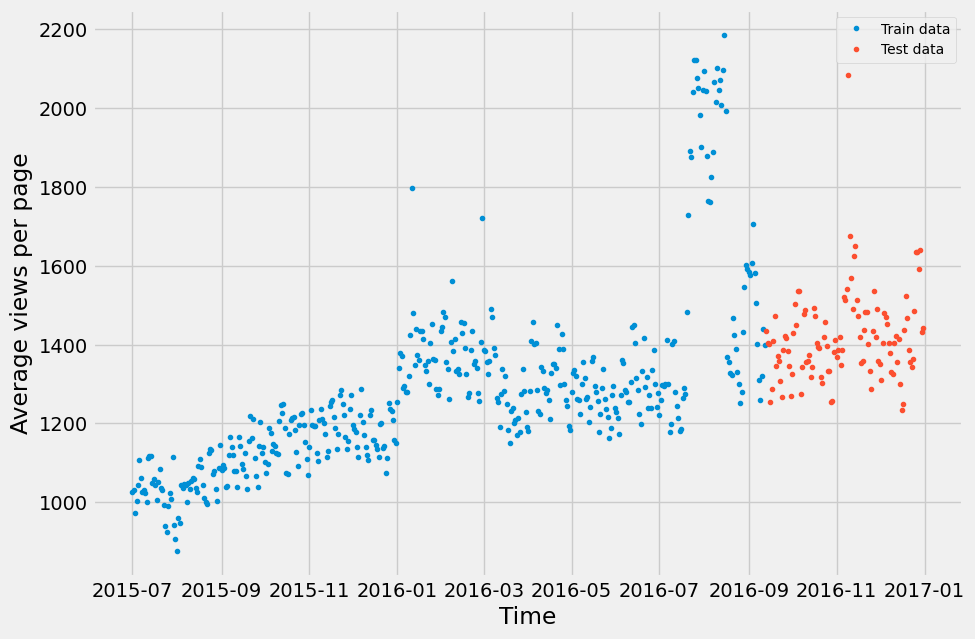

In [ ]:
#Plot Train and Test Data
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([1433.81051681, 1404.73377084, 1402.0029987 , 1254.83527847,
        1287.05234967, 1410.0299594 , 1472.38660444, 1345.67332125,
        1371.3140015 , 1359.26098316]),
 array([1386.42955819, 1357.06710877, 1343.44895666, 1362.47393891,
        1484.41299298, 1634.24213618, 1635.48326589, 1590.91522993,
        1639.88452603, 1431.15953758]))

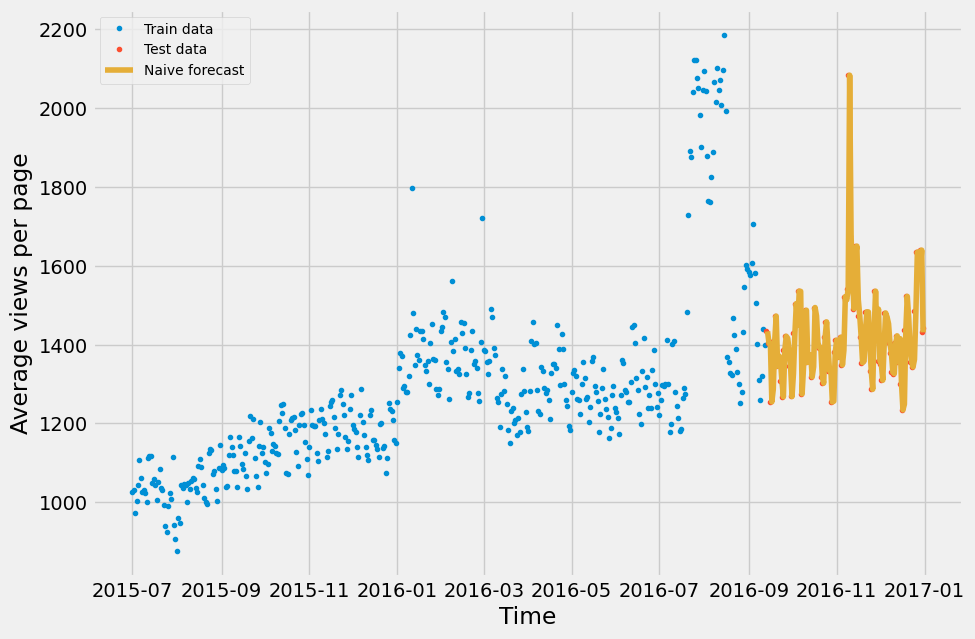

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

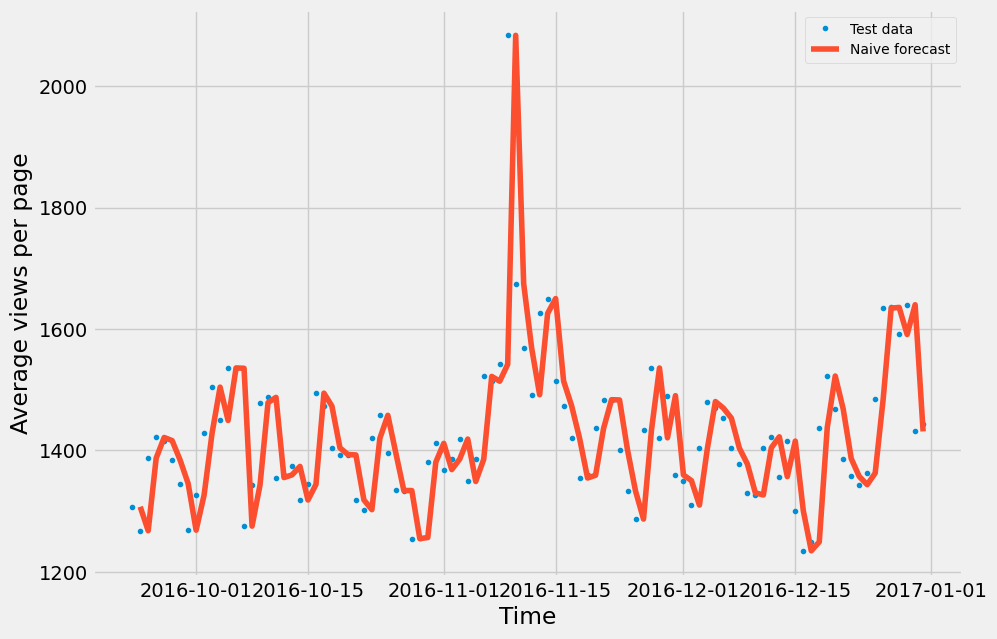

In [ ]:
plt.figure(figsize=(10, 7))
offset = 10 # offset the values by 10 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Evaluating a time series model

In [ ]:
# TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error)
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [ ]:
# Function for different evaluation metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
#Naive Forcast evaluation
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 69.694336,
 'mse': 10496.484,
 'rmse': 102.45235,
 'mape': 4.788169,
 'mase': 0.99463266}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~70 different than the actual

In [ ]:
# Find average views per page in test dataset
tf.reduce_mean(y_test).numpy()

1418.7003085806607

## ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model defined by three key parameters: p (order of autoregressive component), d (degree of differencing for stationarity), and q (order of moving average component). These values determine how past values, differencing, and forecast errors are considered in predicting future values in a time series.

The formula for an ARIMA(p, d, q) model is as follows:

$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} - \theta_1 e_{t-1} - \theta_2 e_{t-2} - \ldots - \theta_q e_{t-q} + e_t$




In [ ]:
# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Split the DataFrame 'df' into training and testing sets
# The 'test_size' parameter specifies the proportion of the data to include in the testing set (in this case, 20%).
# The 'shuffle' parameter is set to False, meaning that the data won't be shuffled before splitting.
# This is useful when working with time series data, where the order of data points matters.
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

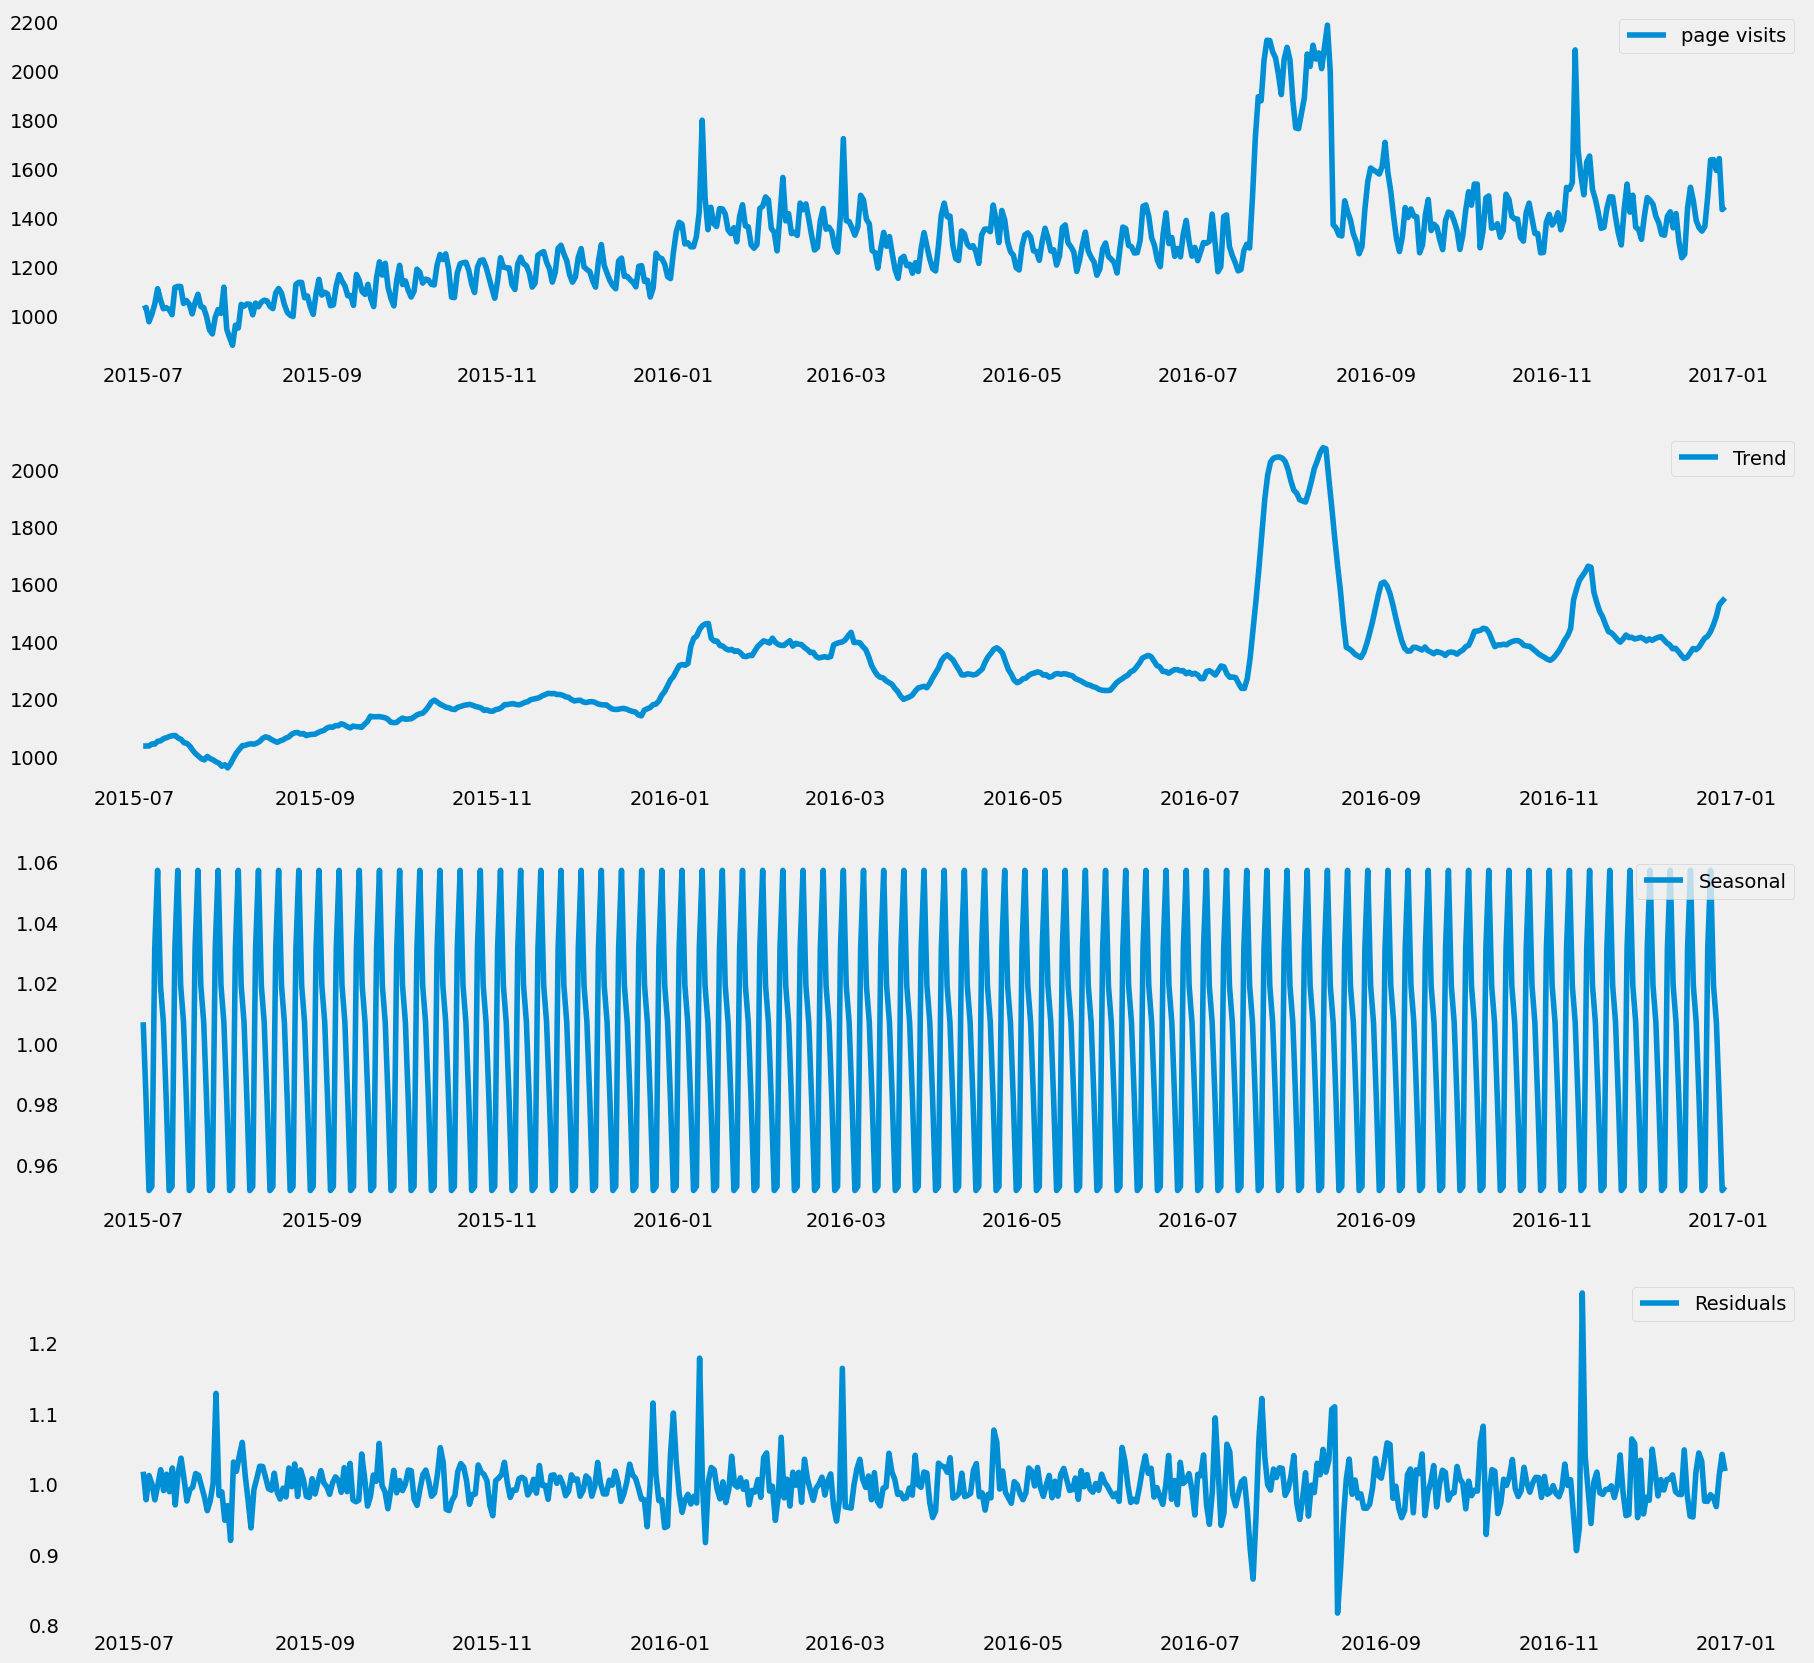

In [ ]:
# Import the necessary module from statsmodels
import statsmodels.api as sm

# Perform seasonal decomposition on the time series data in 'df' using a multiplicative model.
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')

# Extract the trend, seasonal, and residual components from the decomposition.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a figure with four subplots (4 rows, 1 column) and set the figure size.
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# Plot the original time series data on the first subplot.
axes[0].plot(df, label='page visits')
axes[0].grid()
axes[0].legend(loc='upper right')

# Plot the trend component on the second subplot.
axes[1].plot(trend, label='Trend')
axes[1].grid()
axes[1].legend(loc='upper right')

# Plot the seasonal component on the third subplot.
axes[2].plot(seasonal, label='Seasonal')
axes[2].grid()
axes[2].legend(loc='upper right')

# Plot the residual component on the fourth subplot.
axes[3].plot(residual, label='Residuals')
axes[3].grid()
axes[3].legend(loc='upper right')

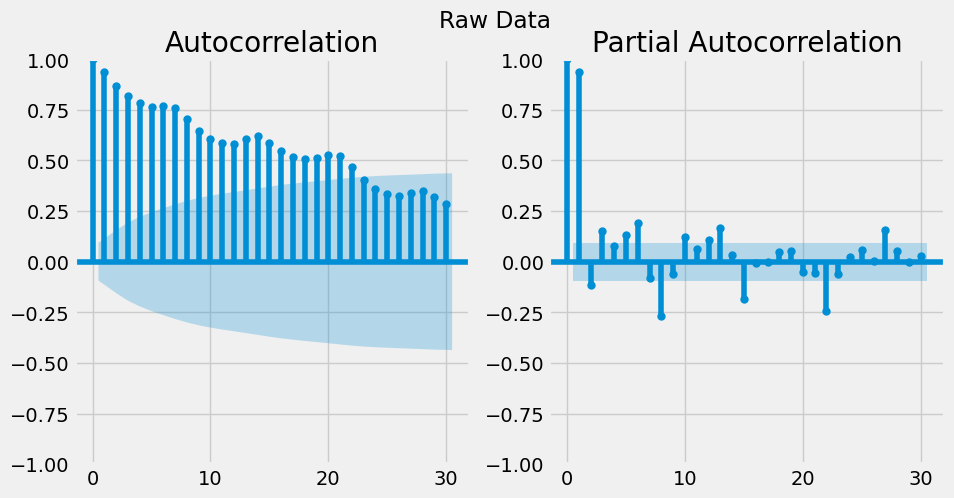

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Set the title for the entire figure.
fig.suptitle('Raw Data')

# Plot autocorrelation function (ACF)
# 'train_df.values.squeeze()' extracts the values from the 'train_df' DataFrame and removes any extra dimensions.
# 'lags' specifies the number of lags to include in the ACF plot (in this case, 30 lags).
# 'ax=ax[0]' specifies that the ACF plot should be drawn in the first subplot.
sm.graphics.tsa.plot_acf(train_df, lags=30, ax=ax[0])

# Plot partial autocorrelation function (PACF)
# 'train_df.values.squeeze()' again provides the data.
# 'lags' specifies the number of lags for the PACF plot (in this case, 30 lags).
# 'ax=ax[1]' specifies that the PACF plot should be drawn in the second subplot.
sm.graphics.tsa.plot_pacf(train_df, lags=30, ax=ax[1])

# Display the figure
plt.show()

The AutoCorrelation Function (ACF) chart shows a gradually decreasing pattern resembling the shape of a sine graph. This pattern is typically indicative of a seasonal non-stationary time series, suggesting the presence of seasonality in the data. To address this seasonality and make the time series stationary, we need to perform differencing

In [ ]:
# Create a copy of the 'train_df' DataFrame.
diff_train_df = train_df.copy()

# Calculate the first-order difference for the 'visit' column.
# This computes the difference between each element and the previous element.
diff_train_df = diff_train_df.visit.diff()

# Drop any rows with missing values (NaN) that may have been introduced by differencing.
diff_train_df = diff_train_df.dropna()

# Rename the column to 'visit'.
diff_train_df.columns = ['visit']

# 'diff_train_df' now contains the first-order differenced time series data in the 'visit' column.


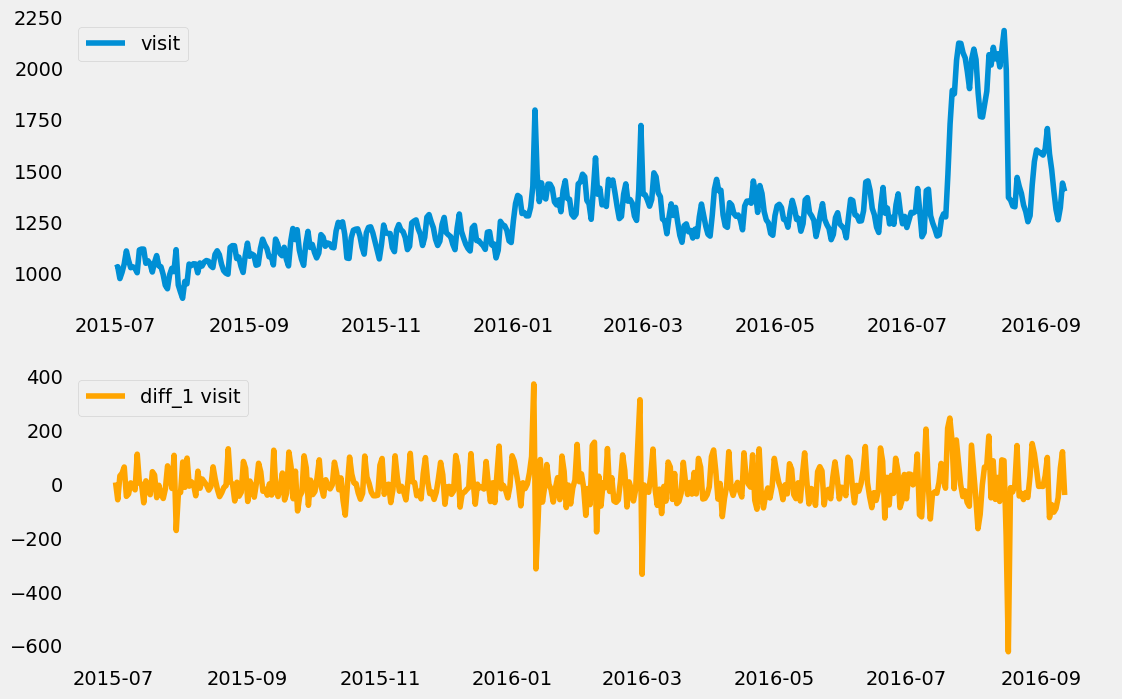

In [ ]:
# Create a figure with two subplots stacked vertically (2 rows, 1 column) and set the figure size.
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot the original 'train_df' time series on the first subplot.
axes[0].plot(train_df.visit, label='visit')
axes[0].grid()
axes[0].legend(loc='upper left')

# Plot the first-order differenced 'diff_train_df' time series on the second subplot in orange.
axes[1].plot(diff_train_df, 'orange', label='diff_1 visit')
axes[1].grid()
axes[1].legend(loc='upper left')


diff_1 visit data looks more stationary than origin visit data
let's plot acf, pacf chart of diff_1 visit data

Test Statistic             -2.248054
p-value                     0.189269
Lags Used                  14.000000
# of Observations Used    425.000000
Critical Value 1%          -3.445831
Critical Value 5%          -2.868365
Critical Value 10%         -2.570405
dtype: float64


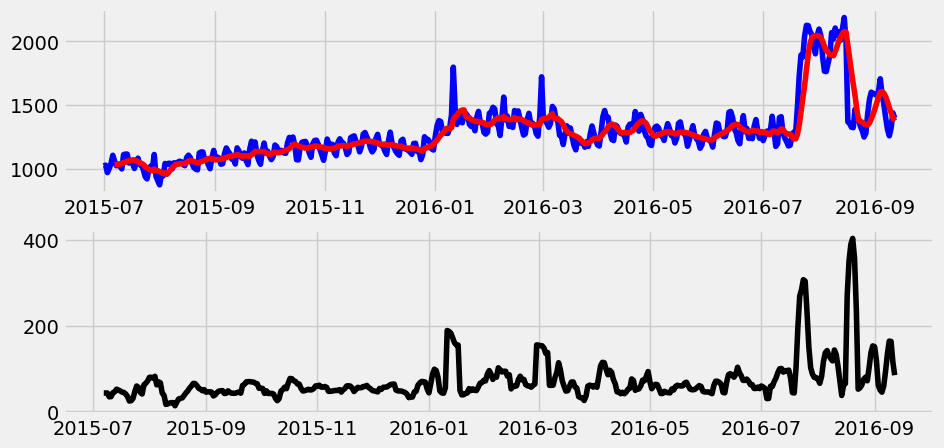

In [ ]:
def test_stationary(df):
    # Create a figure with two subplots stacked vertically (2 rows, 1 column) and set the figure size.
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))

    # Calculate the rolling mean and rolling standard deviation with a window size of 7.
    rolling_mean = df['visit'].rolling(7).mean()
    rolling_std = df['visit'].rolling(7).std()

    # Plot the original time series on the first subplot in blue.
    axes[0].plot(df['visit'], color='blue', label='origin')

    # Plot the rolling mean on the first subplot in red.
    axes[0].plot(rolling_mean, color='red', label='Rolling Mean')

    # Plot the rolling standard deviation on the second subplot in black.
    axes[1].plot(rolling_std, color='black', label='Rolling Std')

    # Add grids to both subplots for better visualization.
    axes[0].grid(True)
    axes[1].grid(True)

    # Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.
    dftest = sm.tsa.adfuller(df['visit'], autolag='AIC')

    # Create a pandas Series to store and print the ADF test results.
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', '# of Observations Used'])

    # Add critical values to the output series.
    for k, v in dftest[4].items():
        dfoutput[f'Critical Value {k}'] = v

    # Print the ADF test results.
    print(dfoutput)

# Call the test_stationary function with the 'train_df' DataFrame.
test_stationary(train_df)


The test statistic (-2.248054) is greater (less negative) than all of the critical values (-3.445831, -2.868365, and -2.570405) at the 1%, 5%, and 10% significance levels. Additionally, the p-value (0.189269) is greater than 0.05.

Based on these results, there isn't enough evidence to reject the null hypothesis of non-stationarity. This suggests that the time series may still exhibit some form of non-stationary behavior.

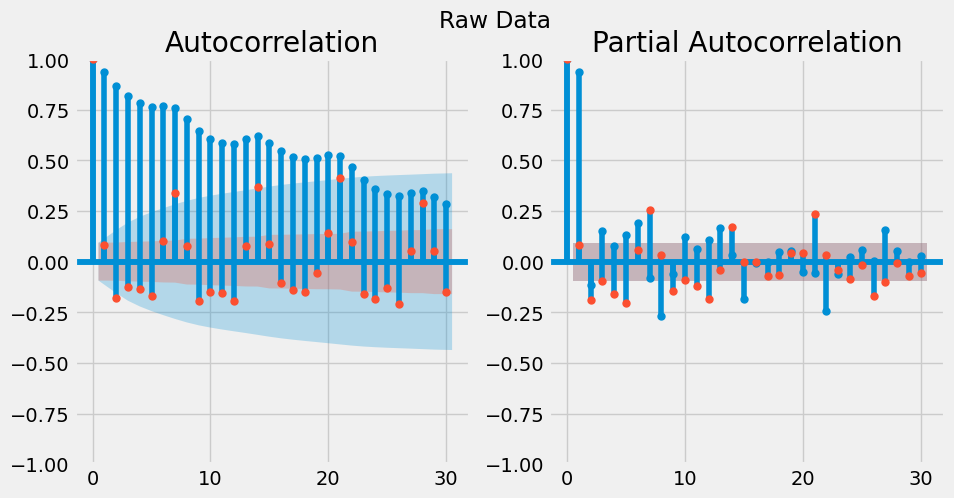

In [ ]:

# fig.suptitle('Diff 1 Visit')
sm.graphics.tsa.plot_acf(diff_train_df.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_df.values.squeeze(), lags=30, ax=ax[1])


### How to set p, d, q ARIMA Model Value in this case, using Graphical Method
In the ACF Chart, the values taper off in a pattern resembling a sine wave. This pattern suggests the suitability of an AutoRegressive (AR) model.

In the Partial AutoCorrelation Function (PACF) chart, a noticeable cutoff occurs after a lag of 3, with values dropping below 0. This pattern indicates that we should set the order of the AR component (p) to 3.

Since we are working with first-order differencing (d = 1) of the 'visit' values, we do not require a Moving Average (MA) component. Typically, MA models are chosen when the ACF Chart exhibits a cutoff after a certain lag (q).

Therefore, based on our analysis, we have selected an ARIMA(3, 1, 0) model to capture the underlying patterns in the data and account for the first-order differencing

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define an ARIMA model with the specified order (p, d, q).
# In this case, (3, 1, 0) indicates an ARIMA(3,1,0) model.
# 'p' is the order of autoregressive terms, 'd' is the degree of differencing, and 'q' is the order of moving average terms.
model = ARIMA(train_df.values, order=(3, 1, 0))

# Fit the ARIMA model to the training data.
model_fit = model.fit()

# Display a summary of the model fit, which includes various statistics and information about the model.
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  440
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2530.194
Date:                Sun, 24 Sep 2023   AIC                           5068.389
Time:                        08:56:35   BIC                           5084.727
Sample:                             0   HQIC                          5074.835
                                - 440                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0809      0.028      2.844      0.004       0.025       0.137
ar.L2         -0.1798      0.040     -4.465      0.000      -0.259      -0.101
ar.L3         -0.0979      0.050     -1.970      0.049      -0.195      -0.000
sigma2      5967.0955    186.539     31.988      0.000    5601.485    6332.706
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1700.66
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from sklearn.metrics import mean_absolute_error
forecast_values = model_fit.forecast(steps=len(test_df))  # Replace test_data with your test data
# Calculate the Mean Absolute Error (MAE) by comparing forecasts to actual values
mae = mean_absolute_error(test_df, forecast_values)
# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 83.39972650381344


Considering the MAE for our ARIMA model, it appears that, on average, each forecast differs from the actual values by approximately 83.40 units. This MAE suggests the level of forecast accuracy achieved by our ARIMA model

The coefficients for lag 1 (ar.L1) and lag 2 (ar.L2) are statistically significant at the 0.05 significance level because their p-values are much lower than 0.05. The coefficient for lag 3 (ar.L3) is marginally significant, as its p-value is close to 0.05.

In [ ]:
# Import the itertools module to generate combinations of p, d, and q.
import itertools

# Define ranges for p, d, and q.
p = range(0, 3)  # Autoregressive order
d = range(1, 3)  # Differencing order
q = range(0, 3)  # Moving average order

# Generate all possible combinations of p, d, and q using itertools.product.
pdq = list(itertools.product(p, d, q))

# Create an empty list to store AIC values.
aic = []

# Iterate through each combination of p, d, and q.
for i in pdq:
    # Create an ARIMA model with the current combination of p, d, and q.
    model = ARIMA(train_df.values, order=i)

    # Fit the ARIMA model to the training data.
    model_fit = model.fit()

    # Print the AIC value for the current combination.
    print(f'ARIMA({i}) AIC : {round(model_fit.aic, 2)}')

    # Append the AIC value to the list.
    aic.append(round(model_fit.aic, 2))


ARIMA((0, 1, 0)) AIC : 5085.69
ARIMA((0, 1, 1)) AIC : 5083.03
ARIMA((0, 1, 2)) AIC : 5069.46
ARIMA((0, 2, 0)) AIC : 5340.47
ARIMA((0, 2, 1)) AIC : 5083.18
ARIMA((0, 2, 2)) AIC : 5080.28
ARIMA((1, 1, 0)) AIC : 5084.64
ARIMA((1, 1, 1)) AIC : 5080.96
ARIMA((1, 1, 2)) AIC : 5058.64
ARIMA((1, 2, 0)) AIC : 5283.33
ARIMA((1, 2, 1)) AIC : 5081.94
ARIMA((1, 2, 2)) AIC : 5078.26
ARIMA((2, 1, 0)) AIC : 5070.61
ARIMA((2, 1, 1)) AIC : 5057.87
ARIMA((2, 1, 2)) AIC : 4994.18
ARIMA((2, 2, 0)) AIC : 5230.47
ARIMA((2, 2, 1)) AIC : 5068.26
ARIMA((2, 2, 2)) AIC : 5056.36


In [ ]:
# Find the index of the minimum AIC value in the 'aic' list.
best_aic_index = aic.index(min(aic))

# Get the corresponding combination of (p, d, q) for the best AIC.
best_p, best_d, best_q = pdq[best_aic_index]

# Print the best AIC value and the corresponding (p, d, q) values.
print(f"Best AIC: {min(aic)}")
print(f"Best (p, d, q): ({best_p}, {best_d}, {best_q})")


Best AIC: 4994.18
Best (p, d, q): (2, 1, 2)


In [ ]:
model = ARIMA(train_df.values, order=(2, 1, 2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  440
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2524.934
Date:                Sun, 24 Sep 2023   AIC                           5057.868
Time:                        08:56:53   BIC                           5074.206
Sample:                             0   HQIC                          5064.313
                                - 440                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7377      0.093      7.967      0.000       0.556       0.919
ar.L2         -0.2479      0.035     -7.090      0.000      -0.316      -0.179
ma.L1         -0.6846      0.096     -7.110      0.000      -0.873      -0.496
sigma2      5795.1955    170.970     33.896      0.000    5460.100    6130.290
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1923.99
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.61   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(2, 1, 2) model has good p-value
let's predict test_df's visit data

In [ ]:
prediction = model_fit.forecast(len(test_df))
prediction_value = prediction
prediction_index = list(test_df.index)

In [ ]:
#ARIMA Forcast evaluation
ARIMA_results = evaluate_preds(y_true=test_df.visit,
                               y_pred=prediction_value)
ARIMA_results

{'mae': 80.42401,
 'mse': 13971.07,
 'rmse': 118.19928,
 'mape': 5.4212046,
 'mase': 1.1539533}

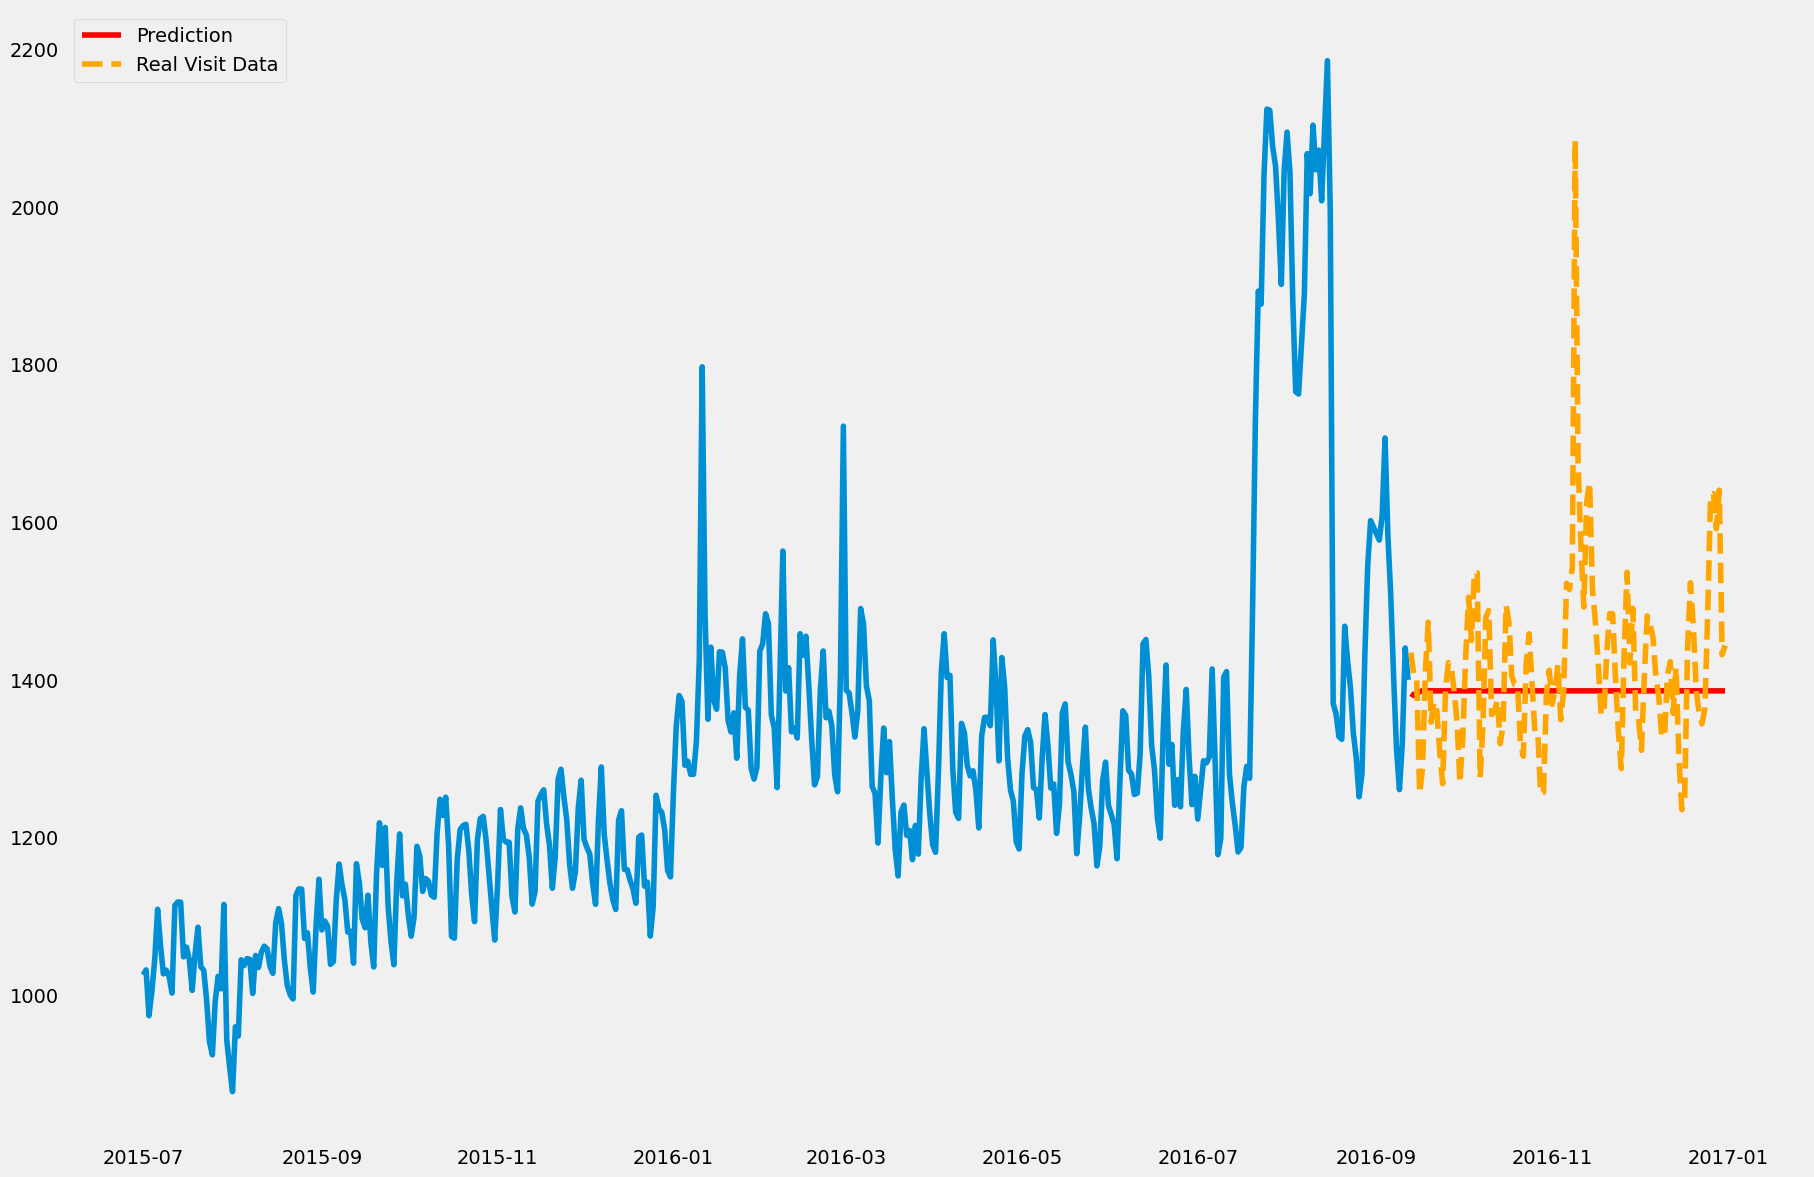

In [ ]:
fig, axes = plt.subplots(figsize=(20, 14))


axes.plot(train_df)
axes.plot(prediction_index, prediction_value,color='r', label='Prediction')
axes.plot(test_df, linestyle='--', color='orange', label='Real Visit Data')
axes.legend(loc='upper left')
axes.grid()

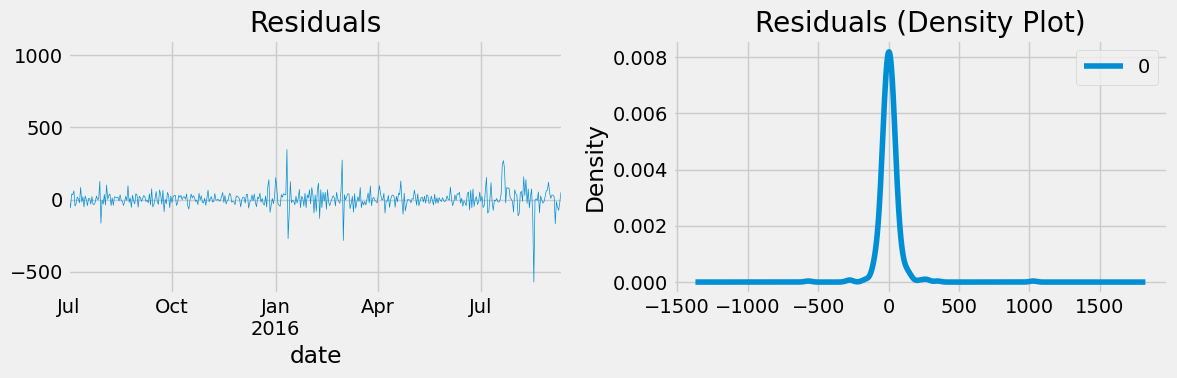

In [ ]:
# Checking for obvious patterns in residuals. Any pattern is a bad sign.
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create a 1x2 grid of plots
residuals = pd.DataFrame(model_fit.resid)

# Plotting residuals
residuals.plot(ax=axs[0], linewidth=0.5, legend=None)
axs[0].set_title('Residuals')

# Density plot of residuals
residuals.plot(kind='kde', ax=axs[1])
axs[1].set_title('Residuals (Density Plot)')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()



The residual has no observable patterns.

## SARIMA

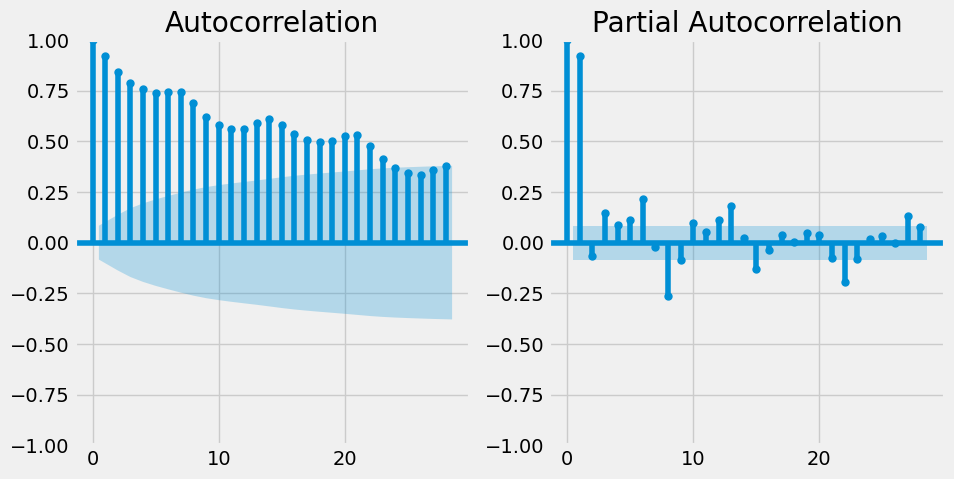

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot autocorrelation function (ACF)
sm.graphics.tsa.plot_acf(df, lags=28, ax=ax[0])

# Plot partial autocorrelation function (PACF)
sm.graphics.tsa.plot_pacf(df, lags=28, ax=ax[1])

# Display the figure
plt.show()

- ACF spikes at seasonal lags (multiples of the seasonal period) suggest the need for a seasonal moving average (SMA) component (Q).
- Beyond the seasonal lags, ACF exhibits a gradual decay in autocorrelation as the lags increase. This decay indicates non-seasonal autocorrelation.


- In the PACF plot, the sharp cutoffs at seasonal lags suggest the need for a seasonal autoregressive (SAR) component (P).
- These sharp cutoffs suggest that the autocorrelation at these lags is primarily explained by the seasonal component.
- PACF is nearly sinusoidal
- Alternating pattern of positive and negative values in the PACF of time series data, it indicates the presence of a seasonal autoregressive (SAR) effect, suggesting that the current and past observations at specific seasonal lags have a significant influence on the time series.

- ACF and PACF decays beyond seasonal lags indicate the presence of non-seasonal autoregressive (AR) and moving average (MA) components (p and q).


- Significant spikes in the ACF and PACF at non-seasonal lags suggest non-seasonal AR and MA orders (p and q).

To estimate the correct parameters, we must use a stationary series.

In [ ]:
#Remove the trend
first_diff = df.diff()[1:]

<Axes: xlabel='date'>

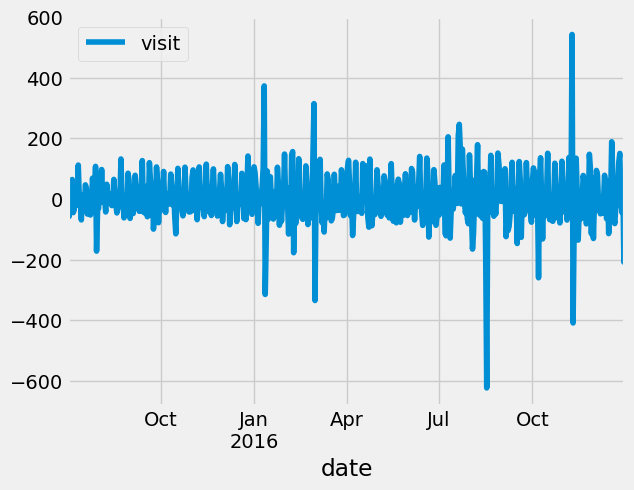

In [ ]:
first_diff.plot()

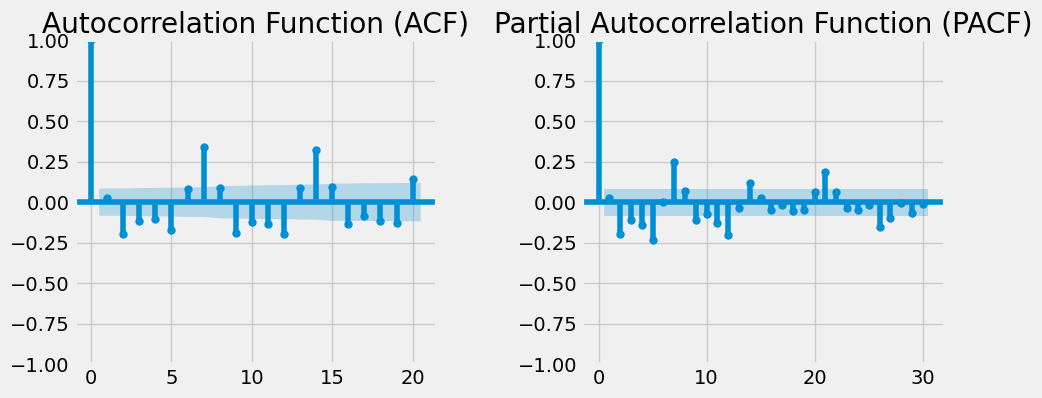

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # Reduce the figure size and adjust the height

# Plot ACF with confidence intervals
sm.graphics.tsa.plot_acf(first_diff, lags=20, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF with confidence intervals
sm.graphics.tsa.plot_pacf(first_diff, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

# Adjust vertical spacing (gap) between the plots
plt.subplots_adjust(wspace=0.4)  # Increase or decrease 'wspace' as needed

plt.show()


##### Observations

- There exists a significant peak in the ACF plot at lag 7 and a significant peak in the PACF plot at lag 7, it suggests a weekly seasonality with s = 7.

- The ACF plot has 2 significant seasonal lags. Thus, number of Seasonal AR terms (P) = 2
The PACF plot has 2 significant seasonal lags. Thus, number of Seasonal MA terms (Q) = 2

- As Dickey-Fuller test indicated that the data is not stationary, we can set d=1 (differencing) in our model. For D (seasonal counterpart of d), I will be using D=1 just because the model fits slightly better in that case compared to D=0.

- Thus, taking, p = 2, q= 2, P = 2, Q =2


SARIMA stands for Seasonal-ARIMA and it includes seasonality contribution to the forecast. The importance of seasonality is quite evident and ARIMA fails to encapsulate that information implicitly.

The Autoregressive (AR), Integrated (I), and Moving Average (MA) parts of the model remain as that of ARIMA. The addition of Seasonality adds robustness to the SARIMA model.

In [ ]:
split_size = int(0.8 * len(df)) # 80% train, 20% test
train_data = df[:split_size]
test_data = df[split_size:]

In [ ]:
p, d, q = 2, 1, 2
P, D, Q = 2, 1, 2
model=sm.tsa.statespace.SARIMAX(train_data['visit'],
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, 7))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             visit   No. Observations:                  440
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -2413.183
Date:                           Sun, 24 Sep 2023   AIC                           4844.366
Time:                                   08:47:37   BIC                           4880.982
Sample:                               07-01-2015   HQIC                          4858.822
                                    - 09-12-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2087      0.136     -1.539      0.124      -0.475       0.057
ar.L2         -0.9165      0.115     -7.969

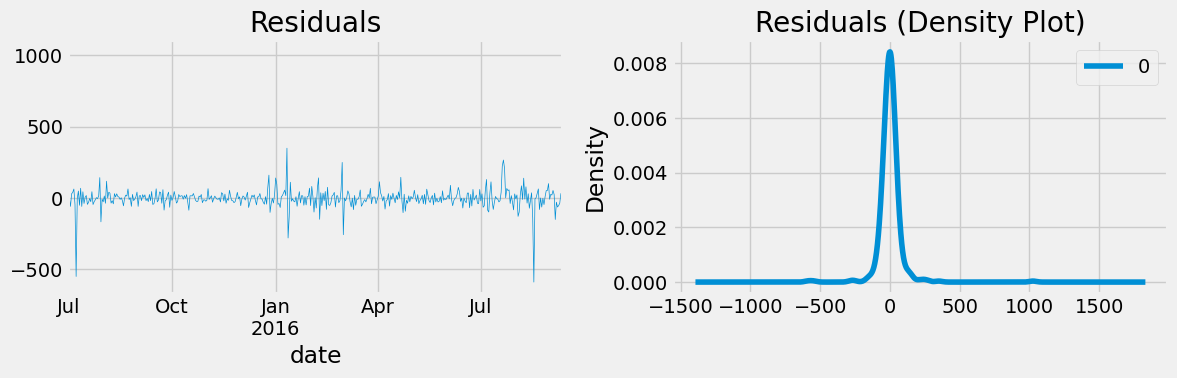

In [ ]:
# Checking for obvious patterns in residuals. Any pattern is a bad sign.
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create a 1x2 grid of plots
residuals = pd.DataFrame(model.resid)

# Plotting residuals
residuals.plot(ax=axs[0], linewidth=0.5, legend=None)
axs[0].set_title('Residuals')

# Density plot of residuals
residuals.plot(kind='kde', ax=axs[1])
axs[1].set_title('Residuals (Density Plot)')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()



The residuals seems to have no observable trend, showing a good fit.

A lack of trend in the residuals indicates that the model's assumptions, including its treatment of seasonality and trends, are appropriate for the data. It suggests that the model is not missing any major patterns or structures in the time series.

Using one-step-ahead predictions, the fit is as follows:

- One-step-ahead predictions, refers to the practice of making predictions for a single time step into the future, based on the available historical data up to the current time step.

- This method is commonly used in real-time forecasting applications, where decisions or actions need to be taken based on the most current information available

- The iterative nature of one-step-ahead predictions allows for incremental learning. Over time, the model can refine its forecasts as it incorporates more recent data, making it well-suited for long-term forecasting tasks.

In [ ]:
import statsmodels.api as sm

# Define SARIMA model parameters (adjust these based on your data and analysis)
p, d, q = 2, 1, 2
seasonal_order = (p, d, q, 7)  # Adjust the seasonal period as needed

one_step_predictions = []

# and 'train_data' with the train set
#max_iterations = df.size - len(train_data)

for i in range(20):
    cut_point = len(train_data) + i
    model = sm.tsa.statespace.SARIMAX(train_data['visit'][:cut_point],
                                      order=(p, d, q),
                                      seasonal_order=seasonal_order)
    result = model.fit()
    one_step_predictions.append(result.predict(cut_point).values[0])


In [ ]:
one_step_predictions

[1351.248685290715,
 1364.6541186820575,
 1329.861719792044,
 1283.7891203704617,
 1266.334135360433,
 1359.4313892762434,
 1396.3774581342725,
 1346.2874059906399,
 1313.6221603630504,
 1290.5847459478407,
 1268.4859455982623,
 1286.3935037356898,
 1403.98030170149,
 1438.9298236015707,
 1374.8078304235096,
 1371.8560047278079,
 1343.9501477387228,
 1298.7500441297261,
 1275.5872318807642,
 1371.3213514782394]

In [ ]:
y_test[:20]

array([1433.81051681, 1404.73377084, 1402.0029987 , 1254.83527847,
       1287.05234967, 1410.0299594 , 1472.38660444, 1345.67332125,
       1371.3140015 , 1359.26098316, 1307.04890978, 1267.58675886,
       1387.19352281, 1421.20396655, 1416.02071514, 1383.8630526 ,
       1345.34442277, 1268.45908329, 1326.51496936, 1428.61013491])

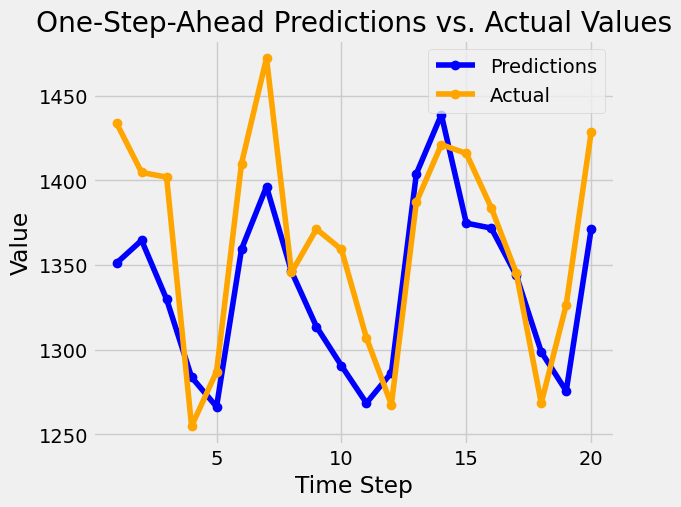

In [ ]:

# Select the first 10 predictions and actual test values for comparison
predictions_to_plot = one_step_predictions
actual_values_to_plot = y_test[:20]

# Create a list of corresponding time steps or indices for the first 10 data points
time_steps_to_plot = range(1, 21)

# Plot the predictions and actual values
plt.figure(figsize=(6, 5))
plt.plot(time_steps_to_plot, predictions_to_plot, marker='o', label='Predictions', linestyle='-', color='blue')
plt.plot(time_steps_to_plot, actual_values_to_plot, marker='o', label='Actual', linestyle='-', color='orange')

plt.title('One-Step-Ahead Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
#SARIMA Forcast evaluation
sarima_results = evaluate_preds(y_test[:20],
                               y_pred=one_step_predictions)
sarima_results

{'mae': 39.152428,
 'mse': 2117.606,
 'rmse': 46.017452,
 'mape': 2.8370266,
 'mase': 0.6647149}

## LSTM

In [ ]:
#time series sequence of values
len(series)

550

In [ ]:
#This line creates a variable X by taking a slice from index 0 to 548 (inclusive).
#This slice represents the input features or independent variables for your time series data.

X = series[0:549]

#This line creates a variable y by taking a slice from index 1 to 549 (inclusive).
#This slice represents the target or dependent variable, which is typically the next value in the time series after the corresponding value in X.
y = series[1:550]


In this setup, X represents the historical values (lagged values) of the time series, and y represents the corresponding values to predict.

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train.shape, y_train.shape)

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
print(X_train.shape, y_train.shape)

X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

(384,) (384,)
(384, 1) (384, 1)


In [ ]:
#Training LSTM

#Reshaping Array
X_train = np.reshape(X_train, (384,1,1))


# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
model = Sequential()

# Adding the input layerand the LSTM layer
model.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


# Adding the output layer
model.add(Dense(units = 1))

model.summary()

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_split=0.3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 4s 30ms/step - loss: 0.1273 - accuracy: 0.0037 - val_loss: 0.1246 - val_accuracy: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0998 - accuracy: 0.0037 - val_loss: 0.0990 - val_accuracy: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0782 - accuracy: 0.0037 - val_loss: 0.0784 - val_acc

In [ ]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (165, 1, 1))

y_pred = model.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

6/6 [==============================] - 0s 5ms/step


In [ ]:
#LSTM Forcast evaluation
LSTM_results = evaluate_preds(y_true=y_test,
                               y_pred = y_pred[:,0])
LSTM_results

{'mae': 58.263725,
 'mse': 6699.984,
 'rmse': 81.85343,
 'mape': 4.3071837,
 'mase': 0.24196838}

Considering the MAE for our LSTM model, it appears that, on average, each forecast differs from the actual values by approximately 58.40 units. This MAE suggests the level of forecast accuracy achieved by our LSTM model

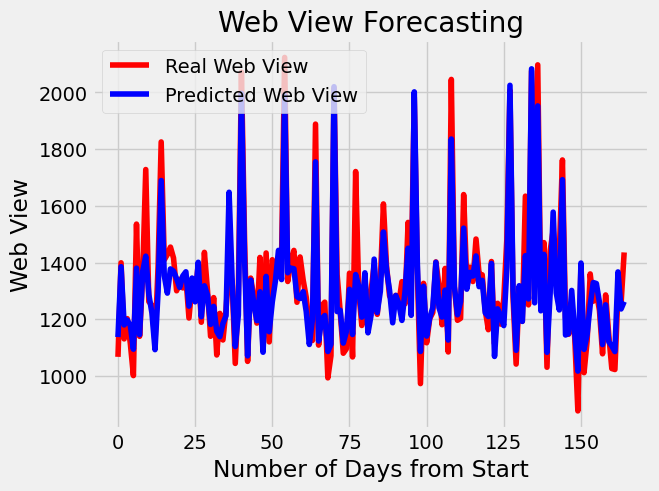

In [ ]:
#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

## Dense Model

The AR and MA models are used for linear prediction for time series analysis. For non-linear predictions, we have neural network models.

#### Windowing dataset

Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

horizon = number of timesteps to predict into future  
window = number of timesteps from past used to predict horizon

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data

# The function takes in an array and turn it into a window and horizon.
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


 Now, create windows for an entire time series using NumPy's array indexing.

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(series, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(543, 543)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [1024.88212708 1031.23360195  973.12338777 1003.79102183 1044.34192041
 1108.08568691 1062.62363938] -> Label: [1026.18111441]
Window: [1031.23360195  973.12338777 1003.79102183 1044.34192041 1108.08568691
 1062.62363938 1026.18111441] -> Label: [1030.80823504]
Window: [ 973.12338777 1003.79102183 1044.34192041 1108.08568691 1062.62363938
 1026.18111441 1030.80823504] -> Label: [1022.82792304]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [1357.06710877 1343.44895666 1362.47393891 1484.41299298 1634.24213618
 1635.48326589 1590.91522993] -> Label: [1639.88452603]
Window: [1343.44895666 1362.47393891 1484.41299298 1634.24213618 1635.48326589
 1590.91522993 1639.88452603] -> Label: [1431.15953758]
Window: [1362.47393891 1484.41299298 1634.24213618 1635.48326589 1590.91522993
 1639.88452603 1431.15953758] -> Label: [1442.97163301]


Turning windows into training and test sets

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(434, 109, 434, 109)

### Dense model (window = 7, horizon = 1)

Simple Architecture for model_1:

- A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
- An output layer with linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
])

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of series
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
4/4 [==============================] - 1s 60ms/step - loss: 1525.5712 - mae: 1525.5712 - val_loss: 1447.1307 - val_mae: 1447.1307
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 1216.8136 - mae: 1216.8136 - val_loss: 1105.7867 - val_mae: 1105.7867
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 905.2693 - mae: 905.2693 - val_loss: 755.3403 - val_mae: 755.3403
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 584.1640 - mae: 584.1640 - val_loss: 396.7940 - val_mae: 396.7940
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 260.7949 - mae: 260.7949 - val_loss: 86.8075 - val_mae: 86.8075
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 113.0858 - mae: 113.0858 - val_loss: 230.2979 - val_mae: 230.2979
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 230.0650 - mae: 230.0650 - val_loss: 240.6942 - val_mae: 240.6942
Epoch 8/100
4/4 [===========

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 4ms/step - loss: 65.3921 - mae: 65.3921


[65.39205169677734, 65.39205169677734]

Making forecasts with a model (on the test dataset)

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds), model_1_preds[:10]

4/4 [==============================] - 0s 3ms/step


(109,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1395.7178, 1364.6293, 1373.6813, 1327.1742, 1347.6775, 1377.333 ,
        1431.8171, 1374.2185, 1363.493 , 1333.9277], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 65.39205,
 'mse': 8853.184,
 'rmse': 94.091354,
 'mape': 4.480847,
 'mase': 0.93323326}

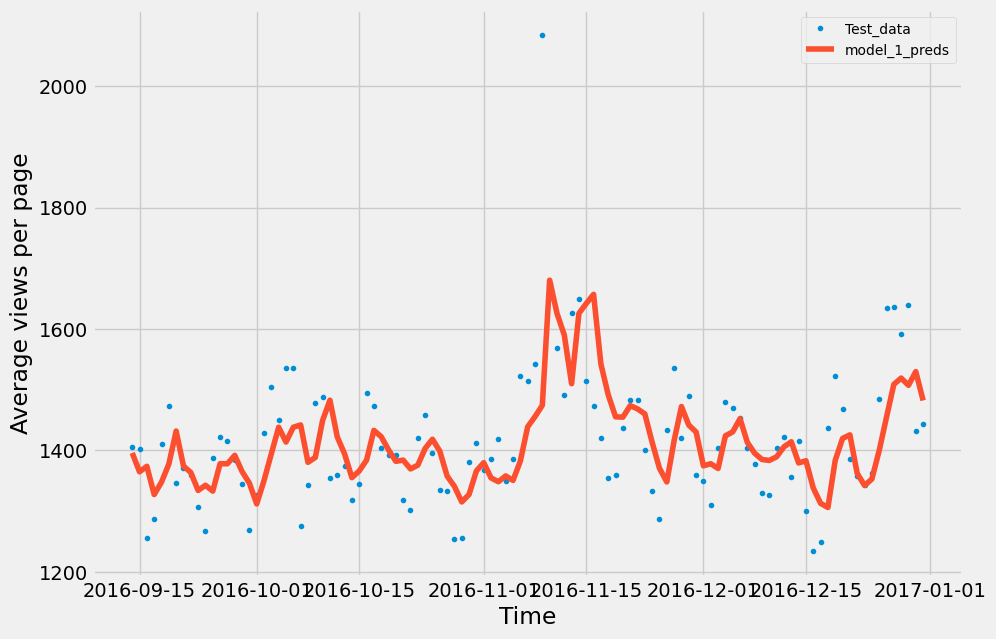

In [ ]:
#Plot model_1 results
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, format="-", label="model_1_preds")

## Conclusion

In [ ]:
# Data for model comparison
data = {
    "Naive": naive_results["mae"],
    "ARIMA": ARIMA_results['mae'],
    'SARIMA': sarima_results["mae"],
    "LSTM": LSTM_results["mae"],
    "horizon_1_window_7": model_1_results["mae"],
}

# Create a DataFrame
df = pd.DataFrame(data, index=["mae"])

- MAE measures the average absolute difference between the predicted values and the actual values.
- In web traffic forecasting, MAE quantifies the average magnitude of prediction errors in terms of the number of visits or pageviews.
- A lower MAE indicates that the model's predictions are closer to the actual traffic data, signifying better accuracy.

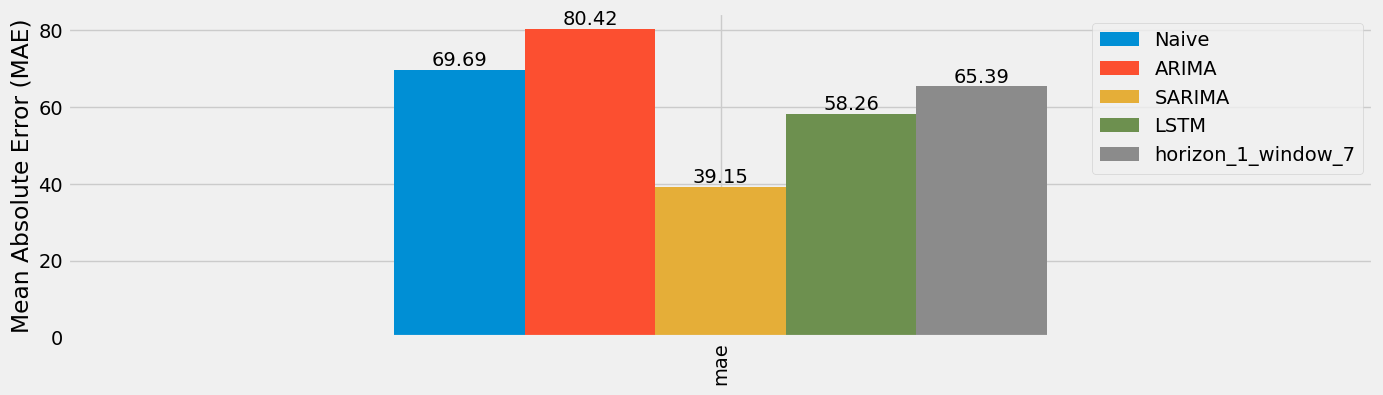

In [ ]:
# Plot with bar values shown
fig, ax = plt.subplots(figsize=(15, 4))
ax = df.plot(kind="bar", ax=ax, legend=True)

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.ylabel("Mean Absolute Error (MAE)")

plt.show()

> ARIMA models do not inherently handle seasonality well and require differencing to make the time series stationary.

> SARIMA extends ARIMA by incorporating seasonal components into the model. It is designed to handle time series data with clear seasonal patterns, which ARIMA alone cannot capture effectively.

> Unlike ARIMA and SARIMA, LSTM is a non-linear model that can capture complex patterns and dependencies in the data. LSTMs excel at capturing long-range dependencies, handling irregular and non-linear data, and modeling sequences of varying lengths.

> SARIMA is effective when dealing with highly seasonal data, while LSTM can capture more complex and non-linear patterns.
- SARIMA requires careful manual tuning of hyperparameters, while LSTM can learn representations from data with minimal feature engineering.
- LSTM may require more data for training effectively and can be computationally expensive.

> The Window Horizon Method (Window = 7, Horizon = 1) is easy to implement and can provide real-time or short-term forecasts since it updates predictions with the latest available data. However, it doesn't capture seasonal patterns effectively. Compared to SARIMA this approach is computationally efficient.

In [ ]:
#Best Model: SARIMA
sarima_results

{'mae': 39.152428,
 'mse': 2117.606,
 'rmse': 46.017452,
 'mape': 2.8370266,
 'mase': 0.6647149}

Based on the MAE value and the information provided, it's reasonable to conclude that the SARIMA model is the best among the models

SARIMA is a robust time series forecasting method, ideal for datasets with evident seasonal patterns. It excels at capturing and modeling recurring patterns in time series data. However, SARIMA assumes the stability of seasonality and patterns over time, making it less suitable for abrupt changes or irregular data. Effective parameter tuning and data preprocessing are essential for SARIMA's success. In summary, SARIMA is a valuable tool in time series analysis and prediction when employed correctly.